# Bibliotecas e DataFrame

In [41]:
# Bibliotecas que iremos usar
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

from prophet import Prophet
import statsmodels.api as sm
import joblib as jb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from warnings import filterwarnings
filterwarnings('ignore')

In [42]:
# Histórico da criptomoeda Shiba Inu em dólares
df = pd.read_csv('SHIB-USD.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,2021-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,78
2,2021-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,2021-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,2021-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,18
...,...,...,...,...,...,...,...
979,2023-09-07,0.000008,0.000008,0.000008,0.000008,0.000008,93343656
980,2023-09-08,0.000008,0.000008,0.000008,0.000008,0.000008,71679178
981,2023-09-09,0.000008,0.000008,0.000008,0.000008,0.000008,51836906
982,2023-09-10,0.000008,0.000008,0.000007,0.000007,0.000007,91324810


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [44]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,0.0,0.0,0.0,0.0,0.0,0
2021-01-02,0.0,0.0,0.0,0.0,0.0,78
2021-01-03,0.0,0.0,0.0,0.0,0.0,2
2021-01-04,0.0,0.0,0.0,0.0,0.0,0
2021-01-05,0.0,0.0,0.0,0.0,0.0,18


# Função que usaremos

In [45]:
# Função de cross validation para testarmos se está ocorrendo algum overfitting no nosso modelo
def cross_validation(train, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    plt.figure(figsize=(12, 6))

    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(train)):
        train_data = train.iloc[train_idx]
        test_data = train.iloc[test_idx]
        
        model = Prophet(changepoint_prior_scale=0.4, growth='linear', seasonality_prior_scale=0.3,
               seasonality_mode='multiplicative', weekly_seasonality=False)
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=len(test_data))
        forecast = model.predict(future)
    
        plt.subplot(2, 3, fold_idx + 1)
        plt.plot(train_data['ds'], train_data['y'], label='Treinamento', color='blue')
        plt.plot(test_data['ds'], test_data['y'], label='Teste', color='green')
        
        plt.plot(forecast['ds'][-len(test_data):], forecast['yhat'][-len(test_data):], label='Previsão', color='red')
    
        plt.title(f'Fold {fold_idx + 1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Exploração dos dados

In [46]:
df.corr(method='pearson').style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.988368,0.993212,0.985717,0.985717,0.542067
High,0.988368,1.000000,0.983482,0.995167,0.995167,0.637940
Low,0.993212,0.983482,1.000000,0.989448,0.989448,0.506815
Close,0.985717,0.995167,0.989448,1.000000,1.000000,0.599942
Adj Close,0.985717,0.995167,0.989448,1.000000,1.000000,0.599942
Volume,0.542067,0.637940,0.506815,0.599942,0.599942,1.000000


In [47]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,984.000000,984.000000,984.000000,984.000000,984.000000,9.840000e+02
mean,0.000013,0.000014,0.000013,0.000013,0.000013,8.942110e+08
std,0.000012,0.000013,0.000011,0.000012,0.000012,2.396671e+09
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000008,0.000008,0.000007,0.000008,0.000008,1.262289e+08
50%,0.000010,0.000010,0.000010,0.000010,0.000010,3.244961e+08
75%,0.000013,0.000014,0.000013,0.000013,0.000013,6.989534e+08
max,0.000079,0.000088,0.000067,0.000080,0.000080,3.905385e+10


- O valor máximo alcançado pelo Shiba Inu foi $0.000088

In [48]:
# Verificando se há algum valor nulo
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

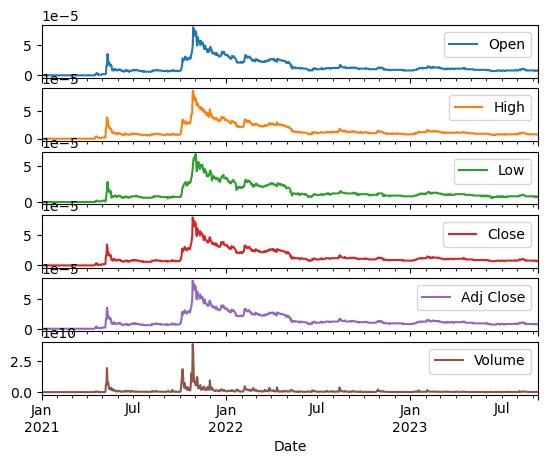

In [49]:
df.plot(subplots=True)

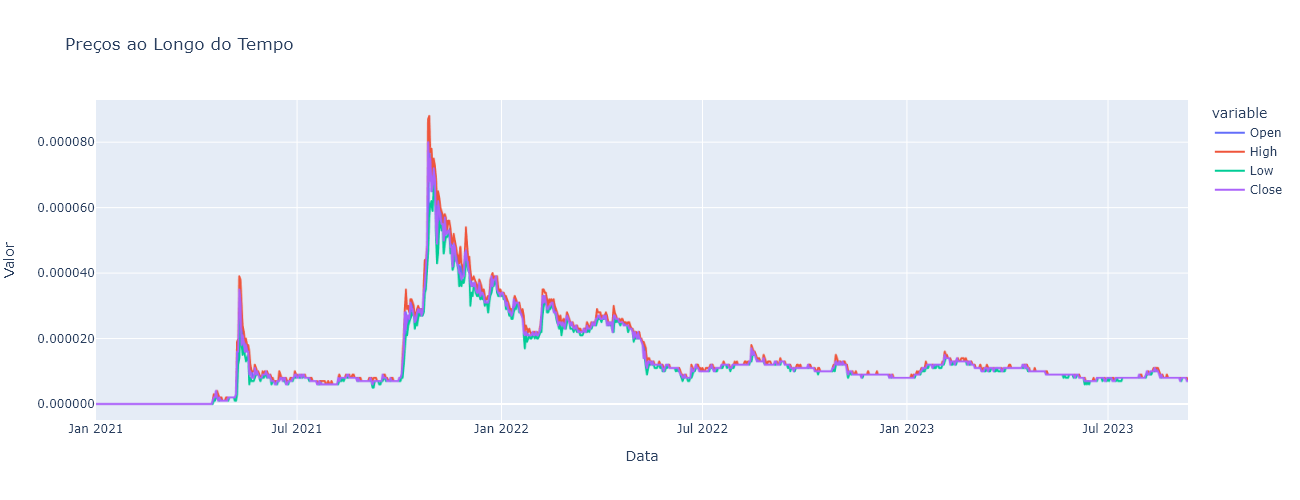

In [73]:
fig = px.line(df, x=df.index, y=['Open', 'High', 'Low', 'Close'], title='Preços ao Longo do Tempo')

fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Valor', tickformat='.6f')
fig.show("png", width=1300)

Com o gráfico acima conseguimos chegar em algumas conclusões:

- O valor mais alto obtido foi no dia 28/10/2021
- Depois da alta absurda em 28/10/2021 o valor só vem caindo

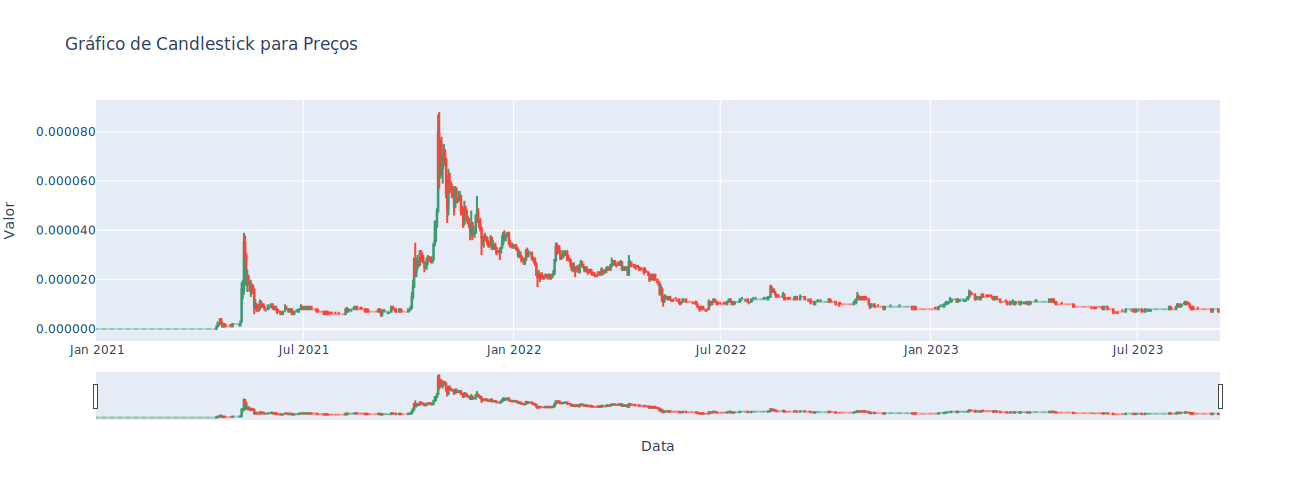

In [51]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(title='Gráfico de Candlestick para Preços')
fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Valor', tickformat='.6f')
fig.show("svg", width=1300)

2021 --> A criptomoeda atingiu um valor gigantesco em outubro e depois foi se decaindo até o fim do ano;

2022 --> A criptomoeda só continuou decaindo;

2023 --> A criptomoeda deu uma leve alavancada entre Janeiro e Março, mas logo após só decaiu, até 11/09/2023.

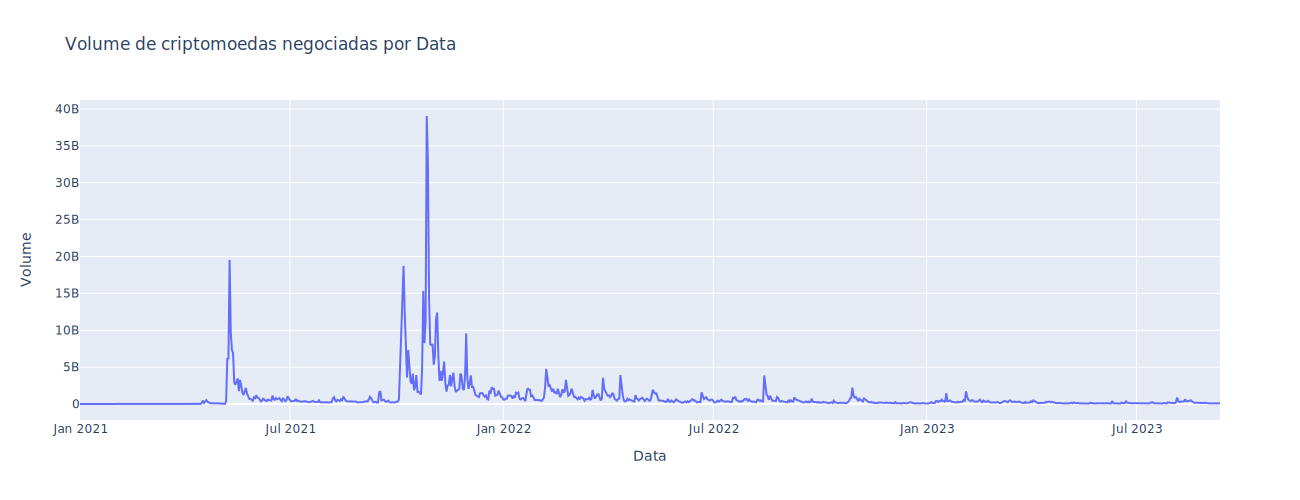

In [52]:
fig = px.line(df, x=df.index, y='Volume', title='Volume de criptomoedas negociadas por Data')
fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Volume')
fig.show("svg", width=1300)

Em maio de 2021, a criptomoeda teve uma alta gigantesca no volume, mas isso ocorreu devido ao grande 'hype' em torno da Shiba Inu naquela época, logo em seguida, já teve uma queda brusca. A partir de setembro de 2021, a liquidez da criptomoeda começou a aumentar, atingindo o pico em 27/08/2021.

Lembrando que o Volume não necessariamente são apenas compras, pode ser vendas ou trocas também. Ou seja, alguns surfaram na onda e lucraram muito, já outros, leigos no assunto, apenas compraram no auge e logo depois já perderam.

In [53]:
# Criação de coluna 'Média'
df['Média'] = (df['High'] + df['Low'])/2

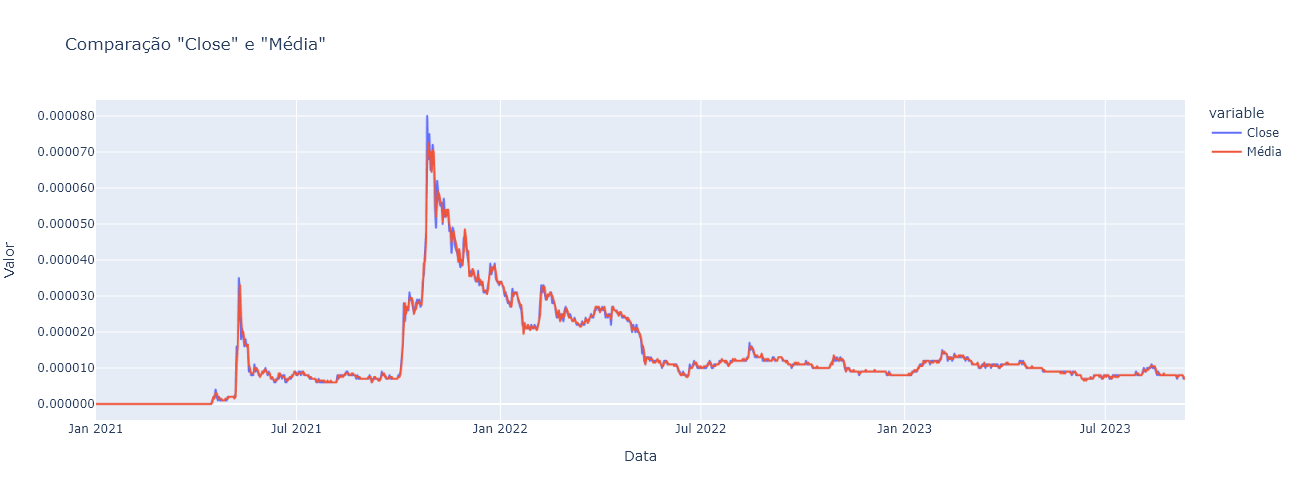

In [74]:
fig = px.line(df, x=df.index, y=['Close', 'Média'], title='Comparação "Close" e "Média"')

fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Valor', tickformat='.6f')
fig.show("png", width=1300)

Uma análise interessante a ser feita, seria comparar o valor de fechamento com a média entre os valores de low e high. Mas o que isso indica?

- Close > Média: Viés alto --> Tendência de alta
- Close < Média: Viés baixo --> Tendência de baixa
- Close = Média: Falta de direção clara

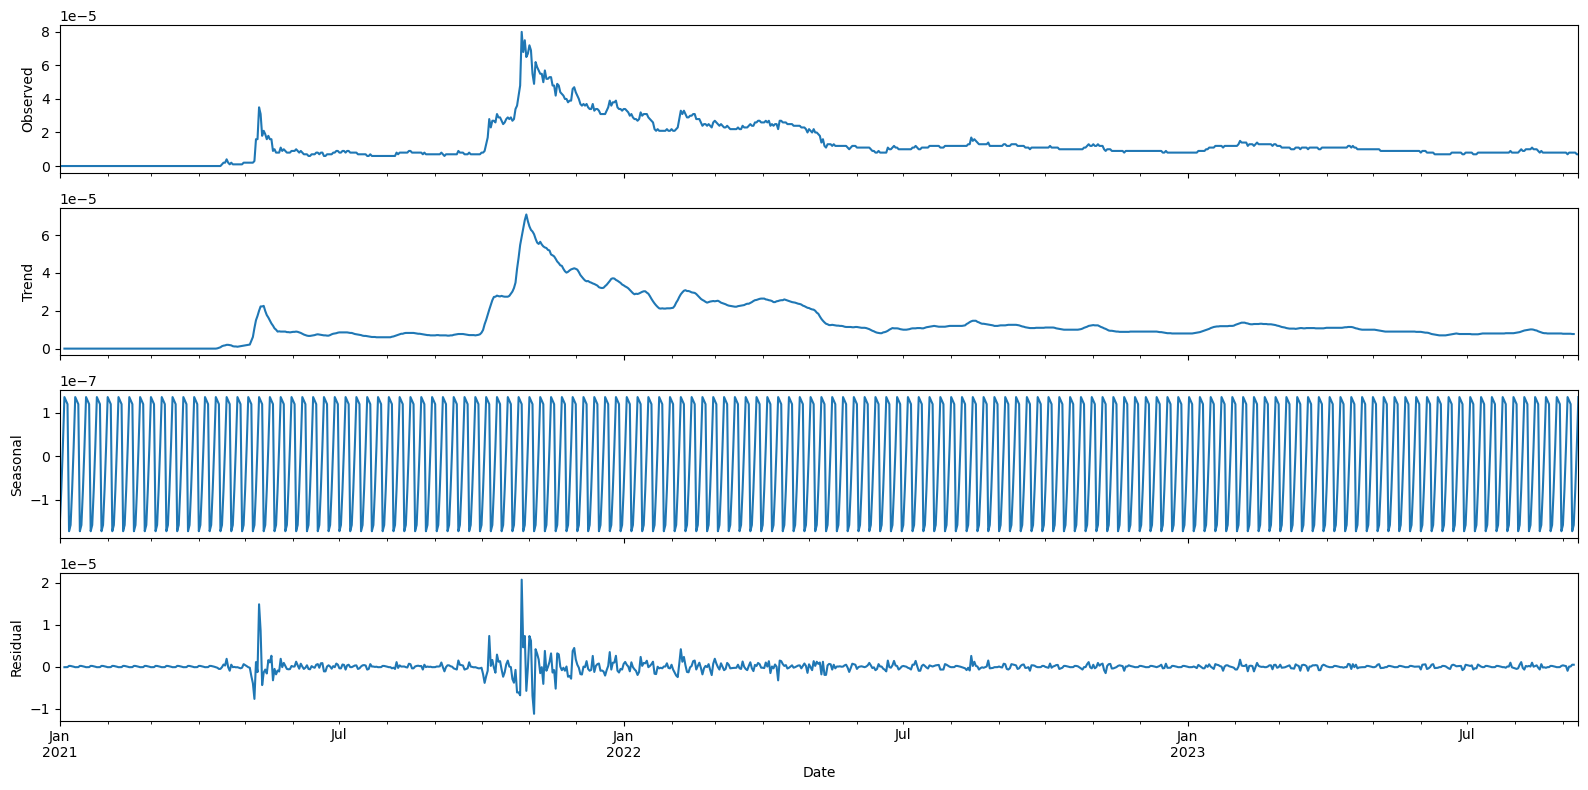

In [55]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive')
fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

decomposition.observed.plot(ax=axes[0])
decomposition.trend.plot(ax=axes[1])
decomposition.seasonal.plot(ax=axes[2])
decomposition.resid.plot(ax=axes[3])

axes[0].set_ylabel('Observed')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

--> Observed (observado): Nosso gráfico original.

--> Trend (tendência): Representa a direção geral dos dados ao longo do tempo de forma suavizada.

--> Seasonal (sazonalidade): Representa os padrões que se repetem em intervalos regulares.

--> Residual (resíduos): Representa os erros ou ruídos restantes após a remoção da tendência e da sazonalidade dos dados.

Com isso, conseguimos observar algumas coisas interessantes:

- O Shiba Inu não teve uma sazonalidade específica durante todo o período, ou seja, seguiu o mesmo padrão de alta e baixa desde o começo.
- Houve muitos ruídos nos momentos de pico (fácil percepção), mas a partir de janeiro de 2022, esses ruídos vêm diminuindo gradualmente.

# Teste de investimento

Agora, apenas por curiosidade, criaremos uma estratégia de compra e venda dessa cripto (Day Trading).

A estratégia consiste em: Se por um acaso uma pessoa sempre comprar essa criptomoeda na abertura do dia e vendê-la no fechamento do dia, ele teria lucrado?

In [56]:
# Criação de colunas auxiliares para nossa estratégia
df['Lucro Diario'] = df['Close'] - df['Open']
df['Lucro Acumulado'] = df['Lucro Diario'].cumsum()

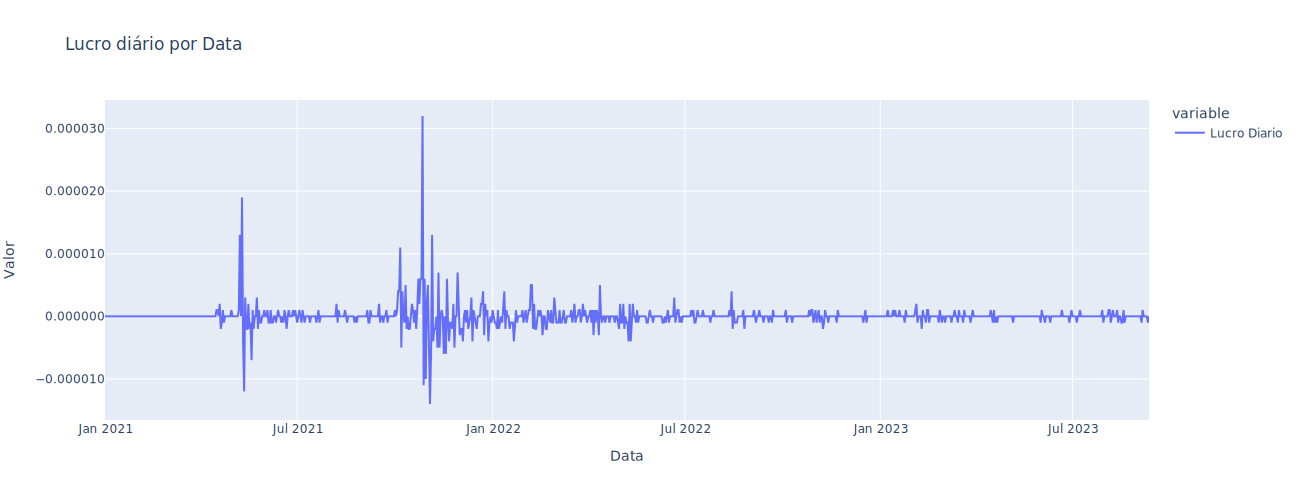

In [57]:
# Gráfico para análise do lucro diário de acordo com a data
fig = px.line(df, x=df.index, y=['Lucro Diario'], title='Lucro diário por Data')

fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Valor', tickformat='.6f')
fig.show("svg", width=1300)

In [58]:
if df['Lucro Acumulado'].iloc[-1] < 0:
    print('A estratégia teria gerado prejuízo.')
    print(f"Lucro acumulado final: {df['Lucro Acumulado'].iloc[-1]}")
else:
    print('A estratégia teria gerado lucro.')
    print(f"Lucro acumulado final: {df['Lucro Acumulado'].iloc[-1]}")

A estratégia teria gerado lucro.
Lucro acumulado final: 2.456395547037471e-20


Como podemos ver, a estratégia, de fato, teria funcionado se alguém a tivesse usado desde o início até 11/09/2023.

# Treinamento do modelo

In [59]:
# dataframe com todos os dados de treinamento
train = df.copy()
train.reset_index(inplace=True)
train.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
train.drop(['Lucro Diario', 'Lucro Acumulado', 'Média'], axis=1, inplace=True)

In [60]:
model = Prophet(changepoint_prior_scale=0.4, growth='linear', seasonality_prior_scale=0.3,
               seasonality_mode='multiplicative', weekly_seasonality=False)
model_fit = model.fit(train)

12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing


# Cross-Validation

12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing
12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing
12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing


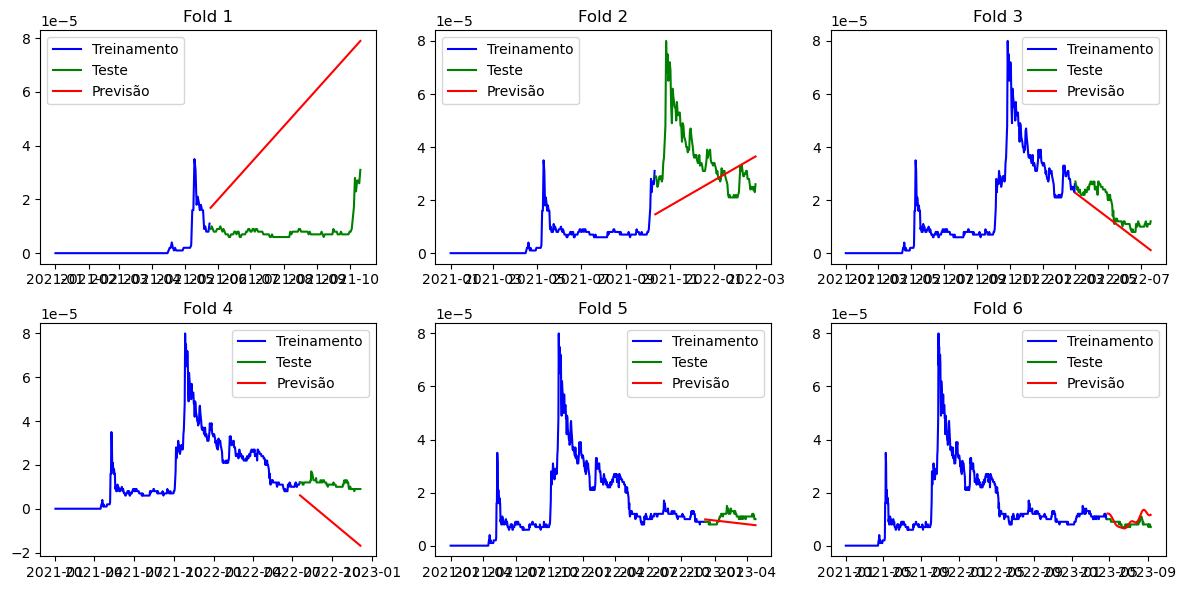

In [61]:
cross_validation(train, 6)

Óbviamente existem muitos erros nos primeiros folds, simplesmente porque ainda não haviam muitos dados a serem avaliados, apenas ruídos no dataset. Conforme vamos colocando mais dados no treinamento, mais ele se aperfeiçoa.

## Métrica MSE

In [62]:
future = model_fit.make_future_dataframe(periods=365)
pred = model_fit.predict(future)

mse = mean_squared_error(train['y'], pred['yhat'][:984])
print(f'MSE: {mse}')

MSE: 7.78633082611644e-12


# Previsão até 11.09.2024

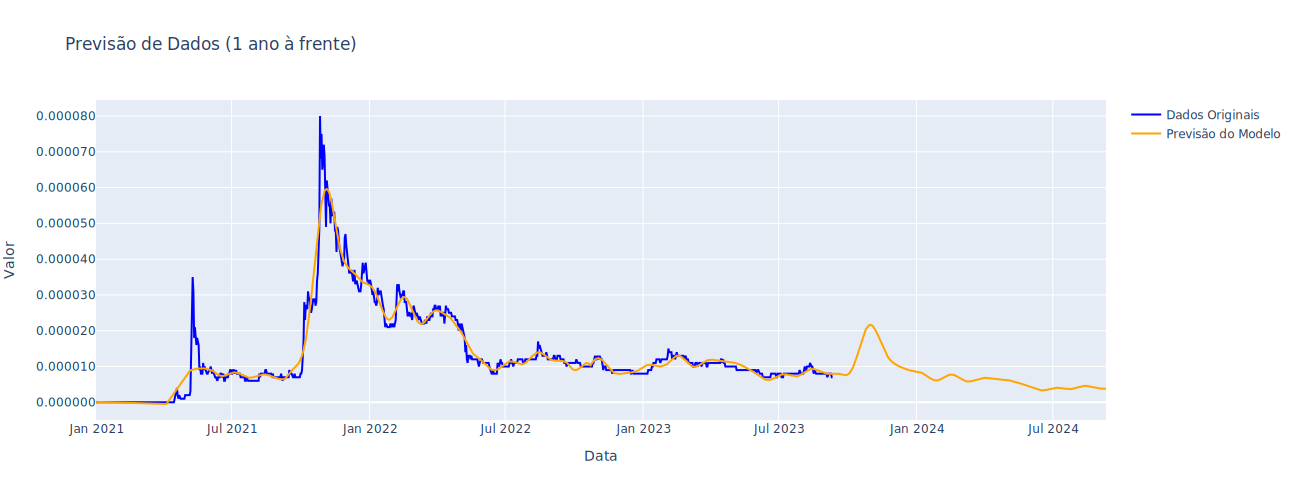

In [70]:
trace1 = go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Dados Originais', line=dict(color='blue'))
trace2 = go.Scatter(x=pred['ds'], y=pred['yhat'], mode='lines', name='Previsão do Modelo', line=dict(color='orange'))

layout = go.Layout(
    xaxis=dict(title='Data'),
    yaxis=dict(title='Valor'),
    title='Previsão de Dados (1 ano à frente)',
    showlegend=True
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.update_yaxes(title_text='Valor', tickformat='.6f')
fig.show("svg", width=1300)

Nossaaa! Agora conseguimos ficar ricos se colocarmos todo nosso dinheiro investido nessa alta prevista para novembro de 2023??

É claro que não, meu amigo! A previsão de uma criptomoeda não é tão simples quanto parece. Existem milhares de fatores para essa criptomoeda ganhar ou perder um certo valor. Mas, de acordo com o modelo Prophet, são esses os valores que ele acha que terá a criptomoeda 1 ano à frente.

"Ah, mas como vamos saber se está correto?"

Apenas esperando o tempo nos dizer.

# Exportação do modelo para produção

In [64]:
jb.dump(model_fit, 'model.pkl')

['model.pkl']